# Connecting the Power Spectrum, Structure Function, and decorrelation Scale

**Purpose**: Code for finding the connection between the frequency spectrum, structure function, and the decorrelation scale.  

**Luke Colosi | lcolosi@ucsd.edu**

## Theoretical Background

For my research project, I want to estimate the dominant length and time scales that characterize the fluid flow and its tracers. By dominant, I am looking for the scale of structures that have the most energy or variance associated with them. However, there can be a board spectrum of structures of present in fluid which all have varying levels of energy. Therefore, I want to estimate the spectra structure of physical processes oocuring at the range of scales. In the case of a spectrum of scales, I want to better understand which scale the decorrelation scale picks out. 

Thus, my research question is: *How is the power spectrum related to the structure function and how does the decorrelation function relate to both of these spectral quantities?*

Let's begin by defining each of these quantities: 

1. Power Spectrum: describes how the variance of a real-valued, stationary physical signal is distributed across positive frequencies. It essentially tells you how much of the signal's power is associated with oscillations at different frequencies. Here we defined the one-sided power spectral density function as: 

$$
E(f) = \langle |X(f)|^2 \rangle
$$

where the averaging corresponds to the averaging over the $n$ fourier transformed segments following the Welch method and X(f) is the complex fourier coefficients defined as:

$$
X(f) = \int^{\infty}_{-\infty} x(t)e^{-i2\pi ft} dt
$$

with $x(t)$ being the time (or space) record of data.  

2. Structure Function: a statistical tool used to quantify variability or fluctuations in a field (like velocity, temperature, or concentration) as a function of spatial or temporal separation. In simplier terms, it tells you how much a quantity changes on average between two points as a function of the distance (or time) between those points. Here, we define the nth order structure function for a field $u(x)$ as:

$$
S_n(\textbf{r}) = \langle |u(x + \textbf{r}) - u(\textbf{r})|^n \rangle 
$$

where $u(x)$ is the value of the field at position $x$, $\textbf{r}$ is the separation (can be spatial or temporal), $n$ is the order of the structure function, and $\langle \cdot \rangle$ is the average over the difference of each data pair for the ith lag. Each order has a different physical interpreation: 

1. **First order $S_1$**: represents the mean absolute difference over scale $r$ which is a rough estimate of the average magnitude of fluctuations or gradients.

2. **Second order $S_2$**: represents the Variance of the difference over separation $r$ which is often used to quantify energy associated with fluctuations — closely related to kinetic energy in turbulence.

3. **Third order $S_3$**: represents the skewness or asymmetry of fluctuations which indicates directionality of the energy cascade (positive vs negative skew).

The structure functions acts as the complement to the autocorrelation such that if $S_2(\textbf{r})$ is small, the variable changes slowly over distance and the field is smooth at that scale. If $S_2(\textbf{r})$ is large the variable changes rapidly over that scale velocity and the field is rough at that scale. Thus, the structure function quantifies how different the values are across a range of separations as opposed to how similar is the field at two points separated by a lag. 

3. Autocorrelation Function and the Decorrelation Scale 

Force matplotlib plots to display directly within the output cell of the notebook: 

In [2]:
%matplotlib inline


Import python libraries


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
#from autocorr import compute_decor_scale, compute_autocorr
#from 

In [15]:
#--- 1D Power Spectrum with the Welch Method ---# 
def spectrum1D_frequency(data, dt, M, units):

    """
    Function for computing the 1D power density spectrum with the Welch method.
    This function is written notationally for time series, but can be applied to spatial data.
    The 1D frequency spectrum is computed by Hanning windowing segments of the data array with 50% overlap.
    
    Parameters
    ----------
    data : Time or spatial data series. Data must be evenly spaced (NaNs must be interpolated).
    dt : Time or spatial interval between measurements.
    M : Number of windows.
    units : 'Hz' (cyclical frequency) or 'rad/s' (radian frequency).
    
    Returns
    -------
    psd : Normalized power spectral density function.
    f : Frequency in units specified by units variable.
    CI : 95% confidence interval.
    variance : Dictionary containing the variance in the time and frequency domains.
    """

    # Import libraries
    import numpy as np
    from spectra import spectral_uncer
    from scipy.signal.windows import hann
    from scipy.signal import detrend

    ###########################################################################
    ## STEP #1 - Set fundamental parameters for computing spectrum
    ###########################################################################

    N = len(data)                 # Number of data points of entire time series
    p = N // M                    # Number of data points within a window

    # Compute frequency resolution
    if units == 'Hz':
        df = 1 / (p * dt)
    elif units == 'rad/s':
        df = 2 * np.pi / (p * dt)

    # Compute number of positive frequencies
    if p % 2 == 0:
        L = p // 2 + 1
    else:
        L = (p - 1) // 2

    # Compute the period of the fundamental frequency (lowest frequency)
    T = p * dt

    # Compute frequency vector (units: Hz or rad/s)
    if p % 2 == 0:
        if units == 'Hz':
            f = (1 / T) * np.arange(0, p // 2 + 1)
        elif units == 'rad/s':
            f = (2 * np.pi / T) * np.arange(0, p // 2 + 1)
    else:
        if units == 'Hz':
            f = (1 / T) * np.arange(0, (p - 1) // 2)
        elif units == 'rad/s':
            f = (2 * np.pi / T) * np.arange(0, (p - 1) // 2)

    ###########################################################################
    ## STEP #2 - Segment data with 50% overlap
    ###########################################################################

    nseg = M + M - 1              # Compute number of segments including 50% overlap

    # Initialize array for splitting time series into windows with 50% overlap
    data_seg_n = data[:M*p].reshape((p, M), order='F')  # Segment original data set

    data_seg_50 = []
    for iseg in range(M - 1):
        ind_i = int(p * iseg + (p / 2))
        ind_f = int(ind_i + p)
        if ind_f <= len(data):
            data_seg_50.append(data[ind_i:ind_f])

    if data_seg_50:
        data_seg_50 = np.stack(data_seg_50, axis=1)
        data_seg_n = np.concatenate((data_seg_n, data_seg_50), axis=1)

    ###########################################################################
    ## STEP #3 - Remove linear trend for each segment and apply hanning window
    ###########################################################################

    # Obtain a hanning window:
    window = hann(p) * np.sqrt(p / np.sum(hann(p)**2))

    # Preallocate windowed detrended segmented data array
    data_seg_w = np.zeros_like(data_seg_n)

    for iseg in range(data_seg_n.shape[1]):
        data_seg_w[:, iseg] = detrend(data_seg_n[:, iseg]) * window

    ###########################################################################
    ## STEP #4 - Compute mean 1D frequency spectrum
    ###########################################################################

    spec_sum = np.zeros(p)                 # Preallocate spectrum summation array
    cn = np.zeros(p)                       # Preallocate counter
    variance = {'time': np.zeros(nseg)}   # Preallocate variance in time domain

    for iseg in range(nseg):
        fft_data_seg = np.fft.fft(data_seg_w[:, iseg])          # Fourier transform data
        amp = np.abs(fft_data_seg)**2                           # Compute amplitudes
        amp_norm = amp / (p**2) / df                            # Normalize amplitudes

        variance['time'][iseg] = np.var(data_seg_w[:, iseg])    # Variance in time domain

        spec_sum += amp_norm                                    # Sum spectrum
        cn += 1                                                 # Update counter

    m_spec = spec_sum / cn                                      # Compute mean spectrum
    psd = m_spec[:L]                                            # Grab positive frequencies

    # Double the amplitude for positive frequencies to conserve variance
    if N % 2 == 0:
        psd[1:-1] *= 2
    else:
        psd[1:] *= 2

    # Compute the variance in frequency space
    variance['freq'] = np.sum(psd * df)

    # Compute 95% confidence interval
    _, CI, _ = spectral_uncer(M, 0.05, psd, 'data')

    return psd, f, CI, variance

In [5]:
#--- Autocorrelation and Autocovariance Function ---# 
def compute_autocorr(data, x, lag, bias, norm = 0):

    """
    rho_pos, rho_neg, R_pos, R_neg, x_ref_pos, x_ref_neg = compute_autocorr(data, x, lag, task, bias, norm = 0)

    Function for computing the autocovariance and autocorrelation 
    functions for positive and negative lag.
    
        Parameters
        ----------
        data : array
            Time or spatial series of data. This data must be preprocessed in the following ways:
            1) Detrend to remove any signal that is undesirable in the autocovariance function.
            2) Missing data gaps are filled with NaN values to ensure a continuous time series.
            3) Flagged data should be replaced with NaN values.
            
        lag : int
            The desired number of lags for computing the correlation. The specified amount of lags is dependent
            on the length of the time series. You want to set the amount of lags to a value where the 
            correlation coefficent is for the proper amount of iterations along to fixed time series.
            Ex: lag_dt = len(data) (compute correlation coefficient at lag decreasing by one measurement at a time).
            
        bias : str
            Specifies whether the covariance is biased or unbiased. The unbiased estimate is normalized by
            1/n-m whereas the biased estimate is normalized by 1/n where n = total number of data points in time
            series and m is the lag time from 0 lag. Furthermore, specifies whether the correlation coefficent is biased 
            or unbaised using the same normalizations in numerator (unbiased (normalized by 1/n-m) or biased
            (normalized by 1/n)) and the normalization 1/n for both cases in the demominator. 
            Options: 'biased' or 'unbiased'.

        norm : int
            Specifies which lagged covariance you want to normalize the autocovariance function by. The normal convention
            is to normalize it by the variance of the data record (the zeroth lag). However in the case where the noise in the
            measurements is causing a large drop in the autocorrelation from the zeroth lag to the first lag (introducing 
            a decorrelation signal different from the decorrelation from the natural variability of the system), normalizing the
            autocovariance function by the first lag will provide a more accurate decorrelation scale. Options includes 0 or 1 
            corresponds to the zero and first lag respectively. Default value: norm = 0. 
            
        Returns
        -------
        rho_pos : array
            Positive lag autocorrelation function.
            
        rho_neg : array
            Negative lag autocorrelation function.
            
        R_pos : array
            Positive lag autocovariance function.
            
        R_neg : array
            Negative lag autocovariance function.

        x_ref_pos : array
            Lag variable for positive lag autocorrelation or autocovariance functions. 

        x_ref_neg : array 
            Lag variable for positive lag autocorrelation or autocovariance functions. 

        Libraries necessary to run function
        -----------------------------------
        import numpy as np 

    """

    # Import libraries 
    import numpy as np

    # Choose interval length n which the correlation coefficient will be computed (Counting and discouting masked elements)
    N = len(data)
    N_eff = np.sum(~data.mask)

    # Initialize autocovariance and autocorrelation arrays
    R         = np.zeros(lag)   # Autocovariance
    rho       = np.zeros(lag)   # Autocorrelation 
    c_pairs_m  = np.zeros(lag)
    c_pairs_nm = np.zeros(lag)

    # Set the normalization factor for the autocorrelation 

    # Normalize by the zeroth lag 
    if norm == 0:

            # Set zero lagged data segments
            running = data[0:N]
            fix = data[:N-0]

            # Remove mean from each segment before computing covariance and correlation
            fix -= np.ma.mean(data)
            running -= np.ma.mean(data)

            # Compute the normalization
            Rnorm = (1/N_eff) * np.ma.dot(fix,running) #np.sum(data * np.conj(data))

    #--- Note ---# 
    # The normalization is the same for the biased, unbiased, and unbiased estimates when normalizing with the zeroth lag
    #  because the factors in front of the inner product are equivalent: 
    # 
    #       1/n_eff = (1 / n_eff) * (n / N) =  1/N_eff
    # 
    # This is because n_eff = N_eff and n = N at tau = 0. Recall that: 
    # 
    #                    n = N - k,
    # 
    # _eff denotes that the quantity excludes masked elements, and upper case N denotes that length of the full record
    # while lower case n denotes the length of the lagged record. 
    
    # Normalize by the first lag 
    elif norm == 1: 

        # Set lagged data segments
        running = data[1:N]
        fix = data[:N-1]

        # Remove mean from each segment before computing covariance and correlation
        fix -= np.ma.mean(data)
        running -= np.ma.mean(data)

        # Compute number of data pairs discounting pairs with masked vaules
        combined_mask = np.logical_or(fix.mask, running.mask)
        n_eff = np.sum(~combined_mask)
        n = len(running)
        
        #--- Unbiased ---# 
        if bias == 'unbiased':
            Rnorm = (1/n_eff) * np.ma.dot(fix,running) # np.sum(data[1:N] * np.conj(data[:N-1]))

        if bias == 'unbiased_tapered':
            Rnorm = (1/n_eff) * (n / N) * np.ma.dot(fix,running) # np.sum(data[1:N] * np.conj(data[:N-1]))

        #--- Biased ---# 
        if bias == 'biased': 
            Rnorm = (1/N_eff) * np.ma.dot(fix,running) # np.sum(data[1:N] * np.conj(data[:N-1]))

    # Loop through each lag interval to compute the correlation and covariance    
    for k in range(lag):

        # Set lagged data segments
        running = data[k:N]
        fix = data[:N-k]
        
        # Remove mean from each segment before computing covariance and correlation
        fix -= np.ma.mean(data)
        running -= np.ma.mean(data)

        # Compute the correlation coefficient terms at lag k
        inner_product = np.ma.dot(fix, running)

        # Compute the number of data pairs counting pairs with masked values
        n = len(running)  # Equivalent to N - k
        c_pairs_m[k] = n

        # Compute number of data pairs NOT counting pairs with masked vaules
        combined_mask = np.logical_or(fix.mask, running.mask)
        n_eff = np.sum(~combined_mask)
        c_pairs_nm[k] = n_eff
        
        # Compute autocorrelation and autocovariance function at lag k

        #--- Unbiased ---# 
        if bias == 'unbiased':
            R[k] = (1 / n_eff) * inner_product
            rho[k] = R[k] / Rnorm

        #--- Unbiased Tapered (Triangular taper) ---# 
        if bias == 'unbiased_tapered':
            R[k] = (1 / n_eff) * (n / N) * inner_product
            rho[k] = R[k] / Rnorm

        #--- Biased ---# 
        elif bias == 'biased':
            R[k] = (1 / N_eff) * inner_product
            rho[k] = R[k] / Rnorm
    
    # Combine positive and negative lag autocorrelation and autocovariance and set the lag vector
    if norm == 0:

        #--- Lag ---#  
        x_ref_pos = x - x[0]
        x_ref_neg = -1 * np.flip(x_ref_pos)[:-1]

        #--- Autocovariance ---# 
        R_pos = R
        R_neg = np.flip(R)[:-1]

        #--- Autocorrelation ---# 
        rho_pos = rho
        rho_neg = np.flip(rho)[:-1]

    elif norm == 1:

        #--- Lag ---#  
        x_ref_pos = x - x[0]
        x_ref_neg = -1 * np.flip(x_ref_pos)[:-1]

        #--- Autocovariance ---# 
        R_pos = R
        R_neg = np.flip(R)[:-1]

        #--- Autocorrelation ---# 
        rho_pos = np.insert(rho[1:], 0, 1) # Set zero lag to unity 
        rho_neg = np.flip(rho)[:-1]
    
    return rho_pos, rho_neg, R_pos, R_neg, x_ref_pos, x_ref_neg #, c_pairs_m, c_pairs_nm (ignoring this output)


#--- Decorrelation Scale Analysis ---%
def compute_decor_scale(autocorr,x_ref,dx,bias,norm):

    """
    Computes the decorrelation scale as an intergral time scale from the positively lag autocorrelation function.  

    Parameters
    ----------
    autocorr : array
            Positive lag autocorrelation function. 

    x_ref : array 
            Lag time or distance independent variable. 

    dx : float 
            The distance between data points in physical space. 

    bias : str
            Specifies whether the covariance is biased or unbiased. The unbiased estimate is normalized by
            1/n-m whereas the biased estimate is normalized by 1/n where n = total number of data points in time
            series and m is the lag time from 0 lag. Options: 'biased' or 'unbiased'.

    norm : int
            Specifies which lagged covariance you want to normalize the autocovariance function by. The normal convention
            is to normalize it by the variance of the data record (the zeroth lag). However in the case where the noise in the
            measurements is causing a large drop in the autocorrelation from the zeroth lag to the first lag (introducing 
            a decorrelation signal different from the decorrelation from the natural variability of the system), normalizing the
            autocovariance function by the first lag will provide a more accurate decorrelation scale. Options includes 0 or 1 
            corresponds to the zero and first lag respectively. Default value: norm = 0. 

    Returns
    -------
    scale : float 
        The integral time scale estimate of the decorrelation scale. 

    Libraries necessary to run function
    -----------------------------------
    import numpy as np 
    from scipy.integrate import trapezoid

    """

    # Import libraries 
    import numpy as np
    from scipy.integrate import trapezoid
    
    # Normalize by the zeroth lag 
    if norm == 0: 

        # Set the positive and negative lagged autocovariance functions
        autocorr_pos = autocorr
        autocorr_neg = np.flip(autocorr)[:-1]

        # Set the positive and negative lag variable
        x_ref_pos = x_ref
        x_ref_neg = -1 * np.flip(x_ref)[:-1]

        # Set the length of data series and data interval
        N = len(autocorr_pos)      # length of one-sided autocorrelation function (and number of samples in data record)
        R = N * dx                 # length of the data series (units of time or space)

        # Initialize scale_N variable
        scale_N = np.zeros(N)

        # Loop through lags 
        for i in range(N):

                # Index autocorrelation function 

                #--- Zeroth lag ---# 
                if i == 0:

                        # Set interal of the autocorrelation function to zero (intergration range vanishes)
                        iscale = 0  

                #--- Higher Order lag ---#     
                else:

                        # Index the autocorrelation function and combine the negative and positive lagged autocorrelation functions 
                        coef = np.concatenate((autocorr_neg[N-i-1:], autocorr_pos[:i+1]))
                        x    = np.concatenate((x_ref_neg[N-i-1:], x_ref_pos[:i+1]))

                        # Compute time or spatial lag
                        r = i * dx

                        # Compute integral of autocorrelation function (with triangular filter weighting lower lags for unbiased estimator)
                        if bias == 'unbiased':
                                iscale = trapezoid((1 - (r / R)) * coef, x, dx=dx)
                        elif bias == 'biased':
                                iscale = trapezoid(coef, x, dx=dx)

                # Save the ith scaling factor=
                scale_N[i] = iscale

        # Find the maximum decorrelation time scale (conservative estimate)
        scale = np.nanmax(scale_N)

    #--- Normalize by the first lag ---#
    elif norm == 1: 

        # Set the positive lagged autocovariance functions
        autocorr_pos = autocorr

        # Set the length of data series and data interval
        N = len(autocorr_pos)  # length of one-sided autocorrelation function
        R = N * dx             # length of the data series

        # Initialize scale_N variable
        scale_N = np.zeros(N)

        # Loop through lags 
        for i in range(N):

                # Index autocorrelation function 

                #--- Zeroth and first lag ---# 
                if i == 0:

                        # Set interal of the autocorrelation function to zero (intergration range vanishes)
                        iscale = 0  

                #--- Higher Order lag ---#     
                else:

                        # Index the autocorrelation function and combine the negative and positive lagged autocorrelation functions 
                        autocor_pos_lag = autocorr_pos[:i+1]

                        # Index the autocorrelation function 
                        x_ref_pos_lag = x_ref[:i+1]

                        # Compute spatial lag
                        r = i * dx

                        # Compute integral of autocorrelation function (using the symmetry across the y-axis)
                        if bias == 'unbiased': 
                               iscale_pos = trapezoid((1 - (r / R)) * autocor_pos_lag, x_ref_pos_lag, dx=dx) 
                        elif bias == 'biased': 
                               iscale_pos = trapezoid(autocor_pos_lag, x_ref_pos_lag, dx=dx) 
                        iscale = 2*iscale_pos

                # Save the ith scaling factor
                scale_N[i] = iscale


        # Find the maximum decorrelation time scale (conservative estimate)
        scale = np.nanmax(scale_N)

    return scale 

In [37]:
def compute_structure_function(field, max_lag, orders=[1, 2, 3, 4]):
    """
    Compute nth-order structure functions using vectorized NumPy operations.
    Supports both 1D (single time series or profile) and 2D (multiple series/profiles) input.
    
    Parameters
    ----------
        field : 1D ndarray 
            Input data, where structure functions are computed.
        max_lag : int
            Maximum lag (spatial or temporal separation).
        orders : list of int
            List of orders (moments) to compute.
        
    Returns
    -------
        S : dictionary 
            Structure functions. Keys are order integers, values are arrays of shape (max_lag,) or (n_series, max_lag)
        lag : 1D ndarray
    """
    
    # Ensure the field is a NumPy array
    field = np.asarray(field)

    # Initialize dictionary for results
    S = {}

    # Set the lag vector
    lag = np.array([lag for lag in range(1, max_lag + 1)])

    # Compute structure functions by lag
    for order in orders:
        
        # For each lag, compute absolute difference to the power of the order
        diffs = [np.abs(field[lag:] - field[:-lag]) ** order for lag in range(1, max_lag + 1)]

        # For each lag, take the mean of the computed differences
        S[order] = np.array([np.mean(d) for d in diffs])

    # Return the dictionary of structure function arrays
    return S, lag

Generate a sinusoidal function 

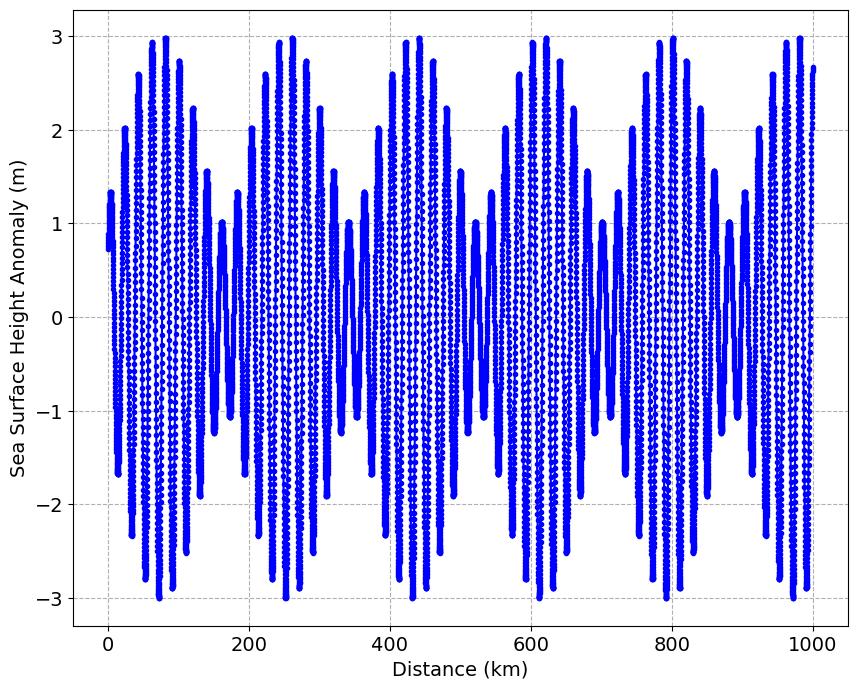

Variance: 2.5711 m^2


In [71]:
# Set signal parameters
A1 = 1;        # Amplitude of signal 1, units: meters
A2 = 2;      # Amplitude of signal 2, units: meters
L1 = 18;         # Wavelength of signal 1, units: km
L2 = 20;       # wavelength of signal 2, units: km
nu1 = 1/L1;    # Cyclical Frequency  
nu2 = 1/L2;    # Cyclical Frequency 
phi1 = 3*np.pi/2 # Phase shift of signal 1, units: radians
phi2 = np.pi/3 # Phase shift of signal 1, units: radians

# Set space parameters
L_tot = 1000  # Extent of signal, units: km
dx = 0.1        # length step intervals, units: km
N = int(np.round(L_tot/dx)) # Number of samples in the the record 

# Compute the space vector 
x = np.linspace(0,L_tot,N)

# Generate normally distributed noise
mean = 0       
std_dev = 0
noise = np.random.normal(mean, std_dev, size=x.shape)

# Compute the fake data with noise
signal = A1*np.sin(2*np.pi*nu1 * x + phi1) + A2*np.sin(2*np.pi*nu2 * x + phi2) # A2*np.sin(2*np.pi*nu2 * x + phi2)
data = signal + noise 

# Convert the fake data to a masked array 
data_m = np.ma.array(data, mask=np.zeros(len(x)))

# Set the fontsize
plt.rcParams.update({'font.size': 14})

# Create figure
fig, axes = plt.subplots(1,1, figsize=(10, 8))

# Plot the time series 
axes.plot(x,data_m,'b.-')
axes.set_xlabel('Distance (km)')
axes.set_ylabel('Sea Surface Height Anomaly (m)')
plt.grid(True, linestyle='--')
plt.show()

# Compute the variance in the time series 
N = len(data_m)
var = ((1 / N) * np.ma.sum((data_m - np.ma.mean(data_m))**2))
print('Variance: ' + str(np.round(var,4)) + ' m^2')


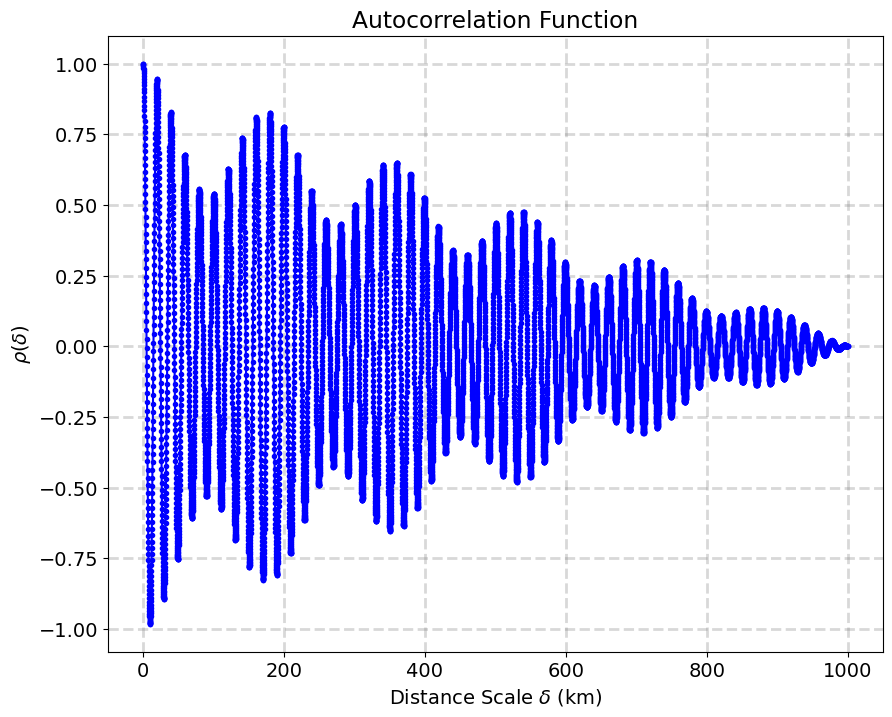

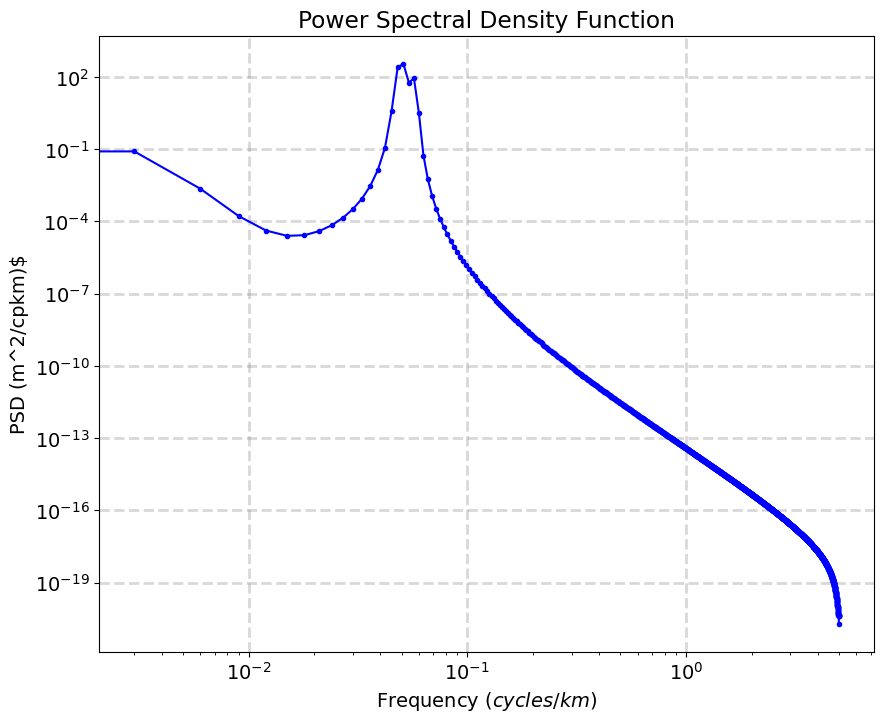

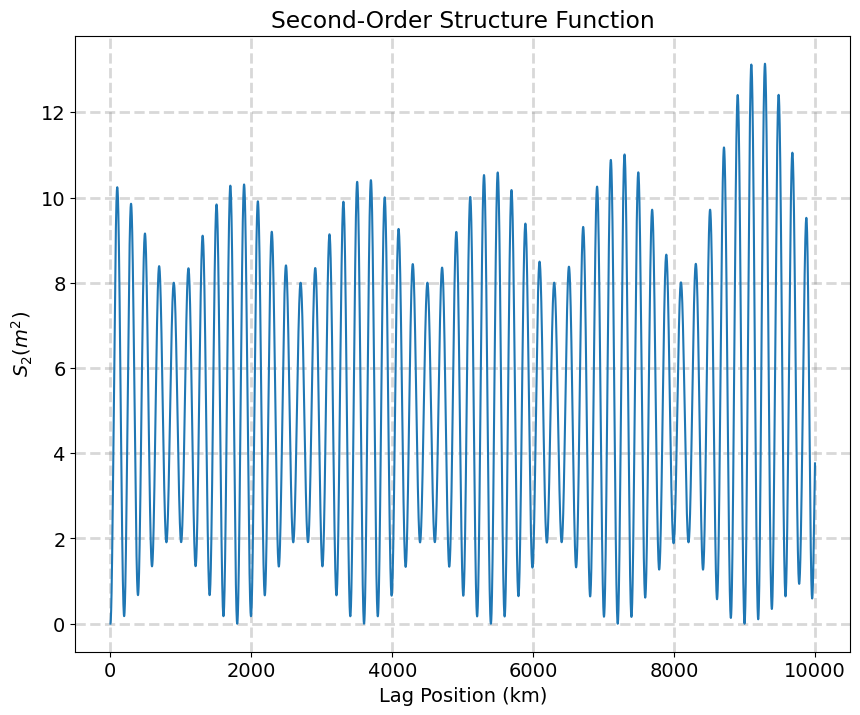

In [72]:
# Set parameters
lag = len(data_m)
estimator = 'biased' 
M = 3
units = 'Hz'

# Compute autocorrelation
autocor_data0, _, autocov_data0, _, x_ref0, _ = compute_autocorr(data_m, x, lag, estimator, 0)
autocor_data1, _, autocov_data1, _, x_ref1, _ = compute_autocorr(data_m, x, lag, estimator, 1)

# Compute the decorrelation scale
scale0 = compute_decor_scale(autocor_data0,x_ref0,dx,estimator,0)
scale1 = compute_decor_scale(autocor_data1,x_ref1,dx,estimator,1)

# Compute spectrum 
psd, f, CI, _ = spectrum1D_frequency(data_m, dx, M, units)

# Compute the structure functions
S, delta_r = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

# Create figure
fig, axes = plt.subplots(1,1, figsize=(10, 8))
axes.set_title("Autocorrelation Function")

# Plot the autocorrelation function 
axes.plot(x_ref0,autocor_data0,'b.-')
if std_dev != 0: 
    axes.plot(x_ref1,autocor_data1,'g.-')
axes.set_xlabel(r'Distance Scale $\delta$ (km)')
axes.set_ylabel(r'$\rho(\delta)$')
axes.grid(linewidth=2, color='gray', alpha=0.3, linestyle="--")
plt.show()

# Create figure
fig, axes = plt.subplots(1,1, figsize=(10, 8))
axes.set_title("Power Spectral Density Function")

# Plot the spectrum 
axes.loglog(f,psd,'.-b')
axes.set_xlabel(r'Frequency ($cycles/km$)')
axes.set_ylabel(r'PSD (m^2/cpkm)$')
axes.grid(linewidth=2, color='gray', alpha=0.3, linestyle="--")
plt.show()

# Create figure
fig, axes = plt.subplots(1,1, figsize=(10, 8))
axes.set_title("Second-Order Structure Function")

# Plot structure Function
axes.plot(delta_r, S[2])
axes.set_xlabel("Lag Position (km)")
axes.set_ylabel("$S_2 (m^2)$")
axes.grid(linewidth=2, color='gray', alpha=0.3, linestyle="--")
plt.show()
